In [11]:
# %%
# TODO add argparse
import os
import sys
import torch
import json
from pathlib import Path
import cv2
import numpy as np
from tqdm.notebook import tqdm

#project_path = Path(__file__).parent.parent
project_path = "../"
#print(project_path)
sys.path.append(project_path)
sys.path.append(os.path.join(project_path, "src"))


from model.model import UnetModel
from datamodule.custom_datasets import CustomDataset
from utils.utils import read_config

from PIL import ImageColor

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches


### Paths definition

In [2]:
path_to_config = "../config/datamodule.yaml"
path_label_classes = "../data/label_classes.json"


### Read config

In [3]:
#path_to_config = os.path.join(project_path, "config", "datamodule.yaml")
data_config = read_config(path_to_config)
# %%
version = "version_4"
model_name = "epoch=50-step=713.ckpt"
checkpoint_path = os.path.join(project_path, "lightning_logs", version, "checkpoints", model_name)


utils.py:INFO: datamodule.yaml config loaded successfully!


### Prepare labels and classes

In [4]:
with open(path_label_classes, "r") as f:
    label_classes = json.load(f)

In [5]:
# prepare labels and colors
cmap = {}
labels = {}
for i, alpha in zip(label_classes, np.linspace(0.5, 1,len(label_classes))):
    color = ImageColor.getcolor(i['color'],"RGB")
    
    cmap[i["png_index"]] = [i/255 for i in color] + [alpha]
    labels[i["png_index"]] = i["name"]
    
cmap[0] = [1,1,1,1]
labels[0] = "background" 

### Load model

In [6]:
pretrained_model = UnetModel.load_from_checkpoint(checkpoint_path=checkpoint_path)
pretrained_model = pretrained_model.to("cuda")
pretrained_model.eval()
pretrained_model.freeze()

### Get data for inference

In [8]:
bees_data = CustomDataset(**data_config["dataset"]["val"], phase="val")

image, mask, img_path = bees_data[1]
print(image.unsqueeze(0).size())


torch.Size([1, 3, 512, 512])


In [14]:
batch_preds = torch.sigmoid(pretrained_model(image.unsqueeze(0).to("cuda")))
batch_preds = torch.argmax(batch_preds.squeeze(), dim=0).detach().cpu().numpy() 



In [15]:
np.unique(batch_preds)

array([0, 1, 2, 4, 7, 8])

  0%|          | 0/512 [00:00<?, ?it/s]

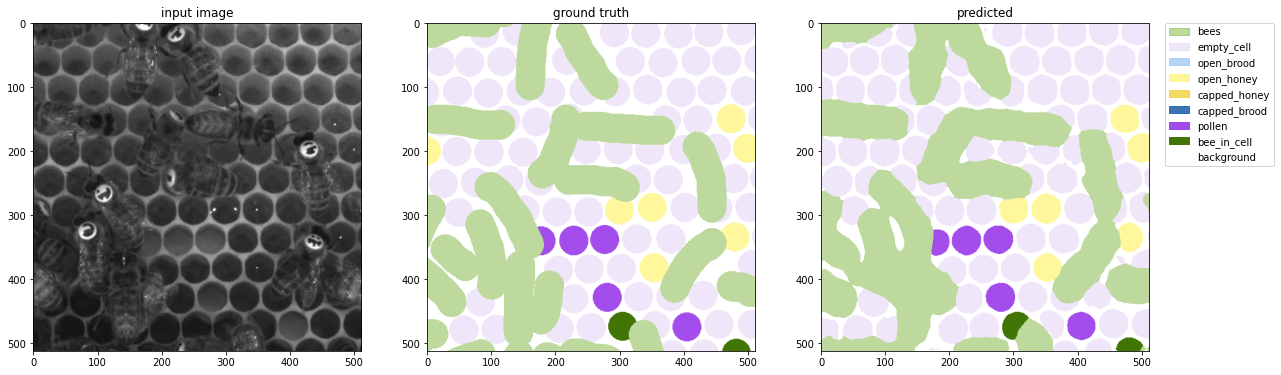

In [19]:



fig, ax = plt.subplots(1, 3, figsize=(20, 14))

ax[0].imshow(cv2.imread(img_path))
ax[0].set_title("input image")

mask_processed = np.array([[cmap[i] for i in j] for j in tqdm(mask.detach().cpu().numpy() )])    

ax[1].imshow(mask_processed)
ax[1].set_title("ground truth")    

label_processed = np.array([[cmap[i] for i in j] for j in batch_preds])
## create patches as legend
patches =[mpatches.Patch(color=cmap[i],label=labels[i]) for i in cmap]


ax[2].imshow(label_processed)
ax[2].set_title("predicted")
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

torch.Size([512, 512])


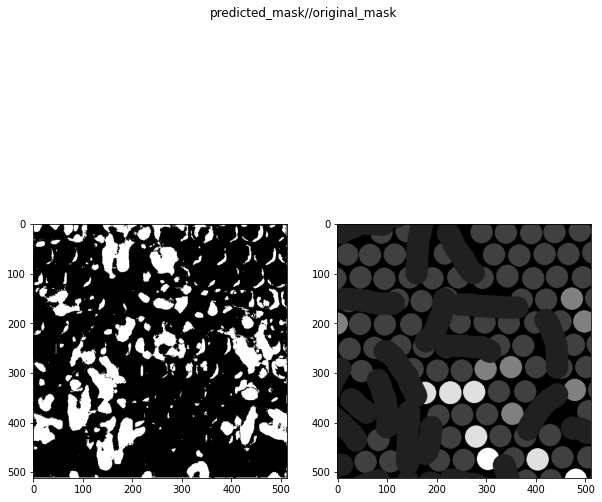

In [25]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10))
fig.suptitle("predicted_mask//original_mask")



print(batch_preds.size())

batch_preds = batch_preds.detach().cpu().numpy()  # convert tensort into numpy
ax1.imshow(
    np.squeeze(batch_preds > 0.5), cmap="gray"
)  # Remove single-dimensional entries from the array. Setting threshold to 0.5
ax2.imshow(np.squeeze(mask), cmap="gray")
#%%

plt.show()


In [ ]:
path_to_save = os.path.join(project_path, "inference", "output", "comparison.png")


In [36]:
import segmentation_models_pytorch as smp


In [95]:
loss =smp.losses.DiceLoss(mode = "multiclass", classes = [0,1,2,3,4,5,6,7,8], from_logits = True)

In [88]:
mask.unsqueeze(0).shape

torch.Size([1, 512, 512])

In [96]:
batch_preds = pretrained_model(image.unsqueeze(0).to("cuda")))


In [97]:
loss(batch_preds, mask.unsqueeze(0).long().cuda())

tensor(0.5422, device='cuda:0')

In [99]:
loss(torch.sigmoid(batch_preds), mask.unsqueeze(0).long().cuda())

tensor(0.5809, device='cuda:0')

In [75]:
mask.unsqueeze(0).unsqueeze(0).size()

torch.Size([1, 1, 512, 512])

In [76]:
loss(mask.unsqueeze(0).unsqueeze(0).long(), mask.unsqueeze(0).long())

RuntimeError: Class values must be smaller than num_classes.

In [69]:
mask.size() == mask.size()

True